In [1]:
import pymc as pm
import numpy as np
import arviz as az
from itertools import combinations

# 7. Coagulation*

An example of Bayesian ANOVA.

Adapted from [Unit 7: anovacoagulation.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/anovacoagulation.odc).

Here 24 animals are randomly allocated to 4 different diets,  but the numbers allocated to different diets are not the same. The coagulation time for blood is measured for each animal. Are the diet-based differences significant? Example from page 166 of [Statistics for Experimenters](https://pages.stat.wisc.edu/~yxu/Teaching/16%20spring%20Stat602/%5bGeorge_E._P._Box,_J._Stuart_Hunter,_William_G._Hu(BookZZ.org).pdf) {cite:t}`box2005statistics`.

In [2]:
# cut and pasted data from .odc file
# fmt: off
times = (62, 60, 63, 59, 63, 67, 71, 64, 65, 66, 68, 66, 71, 67, 68, 68, 56, 62,
         60, 61, 63, 64, 63, 59)
diets = (1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4)
# fmt: on

# create dictionary where each key is a diet and values are lists of times
data = {}
for key, val in zip(diets, times):
    data.setdefault(key, []).append(val)
data

{1: [62, 60, 63, 59],
 2: [63, 67, 71, 64, 65, 66],
 3: [68, 66, 71, 67, 68, 68],
 4: [56, 62, 60, 61, 63, 64, 63, 59]}

## Simple method

No loops! If you're using this style, 4 treatments is probably the max before it starts to get too annoying to type out.

In [3]:
with pm.Model() as m:
    mu0 = pm.Normal("mu_0", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alpha = pm.ZeroSumNormal("alpha", sigma=10, shape=4)

    mu_1 = mu0 + alpha[0]
    mu_2 = mu0 + alpha[1]
    mu_3 = mu0 + alpha[2]
    mu_4 = mu0 + alpha[3]

    pm.Normal("lik1", mu=mu_1, tau=tau, observed=data[1])
    pm.Normal("lik2", mu=mu_2, tau=tau, observed=data[2])
    pm.Normal("lik3", mu=mu_3, tau=tau, observed=data[3])
    pm.Normal("lik4", mu=mu_4, tau=tau, observed=data[4])

    onetwo = pm.Deterministic("α1-α2", alpha[0] - alpha[1])
    onethree = pm.Deterministic("α1-α3", alpha[0] - alpha[2])
    onefour = pm.Deterministic("α1-α4", alpha[0] - alpha[3])
    twothree = pm.Deterministic("α2-α3", alpha[1] - alpha[2])
    twofour = pm.Deterministic("α2-α4", alpha[1] - alpha[3])
    threefour = pm.Deterministic("α3-α4", alpha[2] - alpha[3])

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,63.995,0.527,63.016,65.002,0.004,0.003,22143.0,14304.0,1.0
tau,0.179,0.056,0.079,0.282,0.000,0.000,14655.0,13754.0,1.0
alpha[0],-2.969,1.028,-4.888,-1.002,0.008,0.006,18356.0,14838.0,1.0
alpha[1],1.987,0.881,0.339,3.677,0.006,0.004,21811.0,14707.0,1.0
alpha[2],3.964,0.889,2.228,5.595,0.007,0.005,17327.0,13918.0,1.0
alpha[3],-2.981,0.816,-4.542,-1.460,0.005,0.004,23383.0,16548.0,1.0
α1-α2,-4.956,1.605,-8.018,-1.969,0.012,0.008,19430.0,14471.0,1.0
α1-α3,-6.933,1.608,-9.829,-3.745,0.012,0.009,17433.0,14669.0,1.0
α1-α4,0.012,1.534,-2.908,2.880,0.011,0.010,20750.0,15189.0,1.0
α2-α3,-1.977,1.430,-4.704,0.699,0.010,0.008,19332.0,14482.0,1.0


Text(0.5, 1.0, 'Ridgeplot of $\\alpha$ and contrasts')

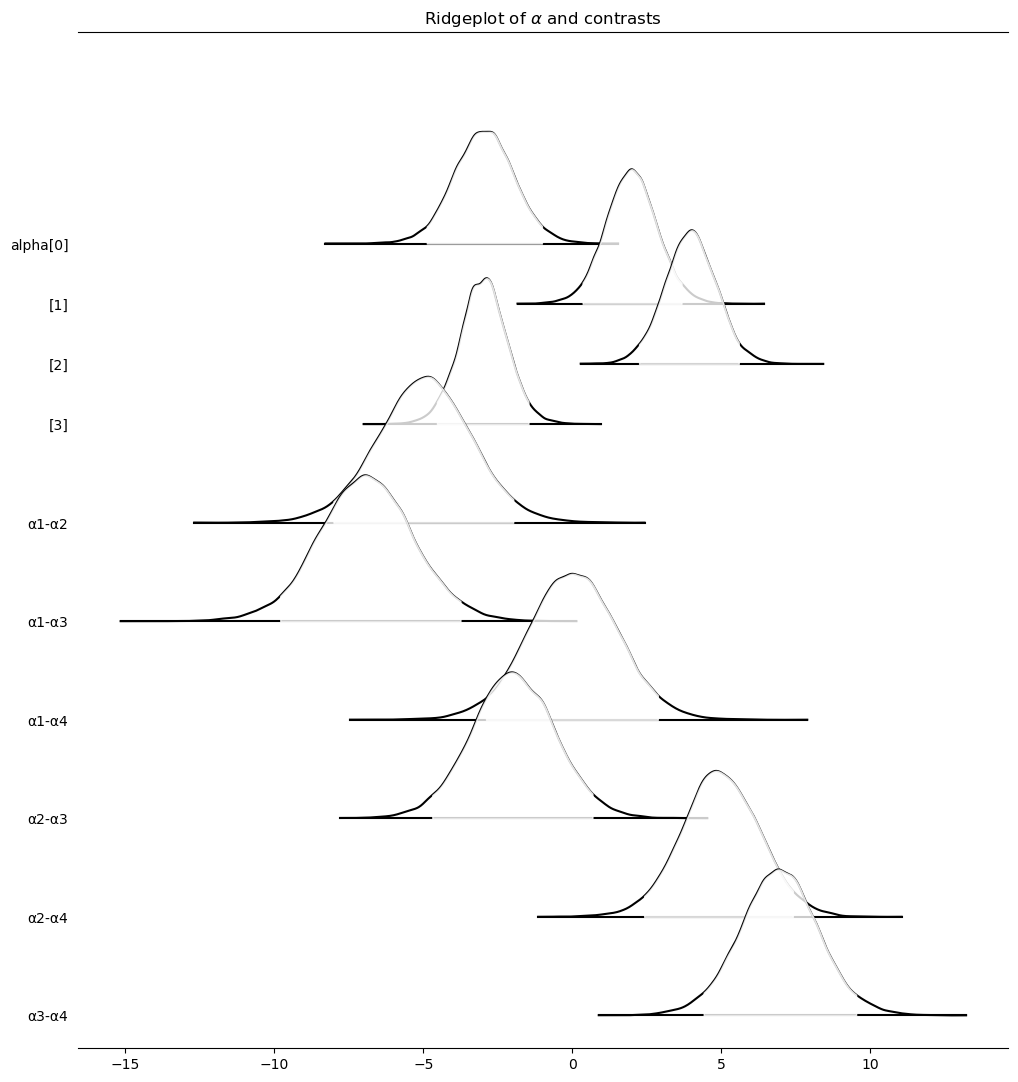

In [31]:
axes = az.plot_forest(
    trace,
    var_names=["~mu_0", "~tau"],
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=False,
    ridgeplot_overlap=2,
    ridgeplot_alpha=0.8,
    colors="white",
)

axes[0].set_title("Ridgeplot of $\\alpha$ and contrasts")

## A more concise method
Not necessarily pretty, but easier to extend to more treatments. I'm interested in seeing other peoples' methods here; I feel like this could still be a lot cleaner.

In [32]:
# get possible combinations
combos = list(combinations(range(4), 2))
combos

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [35]:
with pm.Model() as m:
    mu0 = pm.Normal("mu0", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alphas = pm.ZeroSumNormal(f"αlpha", sigma=10, shape=4)
    mus = [
        pm.Deterministic(f"mu{i + 1}", mu0 + alpha) for i, alpha in enumerate(alphas)
    ]

    [
        pm.Normal(f"lik{i + 1}", mu=mus[i], tau=tau, observed=data[i + 1])
        for i, mu in enumerate(mus)
    ]

    [pm.Deterministic(f"α{i + 1} - α{j + 1}", alphas[i] - alphas[j]) for i, j in combos]

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, tau, αlpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [36]:
az.summary(trace, var_names=["α"], filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
αlpha[0],-2.939,1.011,-4.829,-0.999
αlpha[1],1.967,0.876,0.364,3.655
αlpha[2],3.951,0.883,2.338,5.703
αlpha[3],-2.979,0.806,-4.480,-1.425
α1 - α2,-4.906,1.583,-8.008,-1.957
α1 - α3,-6.890,1.590,-9.849,-3.831
α1 - α4,0.040,1.509,-2.810,2.910
α2 - α3,-1.985,1.423,-4.684,0.646
α2 - α4,4.946,1.327,2.491,7.478
α3 - α4,6.931,1.335,4.515,9.526


In [37]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sat Mar 08 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pytensor: 2.26.4

numpy: 1.26.4
arviz: 0.20.0
pymc : 5.19.1

